# Make anyone be recognized as Steve Jobs

Adversarial examples are created as described in https://www.anishathalye.com/2017/07/25/synthesizing-adversarial-examples/

In [2]:
%matplotlib notebook
from matplotlib import rc
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FuncFormatter
import tensorflow as tf
from vggface.tf_model import VGGFace
from keras_vggface.utils import decode_predictions
from scipy.misc import imread
import numpy as np
import os

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=True)
params = {'text.latex.preamble': [r"\usepackage{amsmath}", r"\usepackage{bm}"]}
plt.rcParams.update(params)

weights_file = os.path.expanduser("~/.keras/models/vggface/rcmalli_vggface_tf_vgg16.h5")

Restore model from checkoint

In [3]:
sess = tf.InteractiveSession()
img_var = tf.Variable(tf.zeros((224, 224, 3)))

cnn_output, cnn_output_logits = VGGFace.model(tf.expand_dims(img_var, 0), drop_rate=0)
VGGFace.load(sess, weights_file)

In [4]:
def classify(img):
    img_preprocessed = VGGFace.preprocess(img.astype(np.float))
    feed_dict = {img_var: img_preprocessed}
    
    class_probabilities = sess.run(cnn_output, feed_dict=feed_dict)
    return decode_predictions(class_probabilities)

<IPython.core.display.Javascript object>


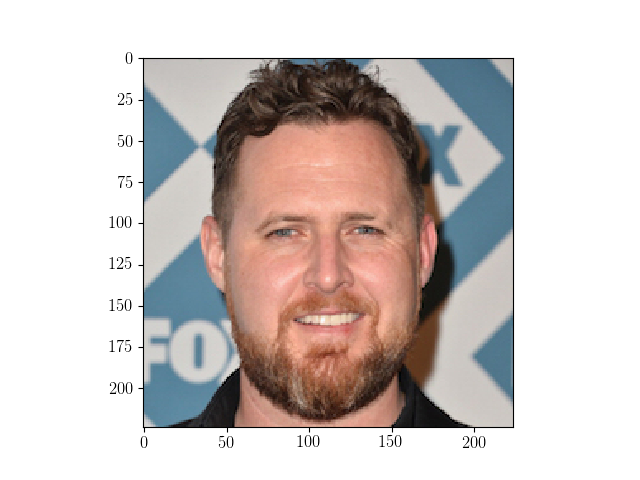

[[["b'A.J._Buckley'", 0.9790116],
  ["b'David_Denman'", 0.0014457356],
  ["b'Carmine_Giovinazzo'", 0.00086765352],
  ["b'Robert_Buckley'", 0.00072456943],
  ["b'Eddie_Cahill'", 0.00041833144]]]

In [5]:
img_filename = "../keras-vggface/image/ajb.jpg"
img = imread(img_filename).astype(np.float)
plt.imshow(img.astype(np.uint8))
classify(img)

<IPython.core.display.Javascript object>


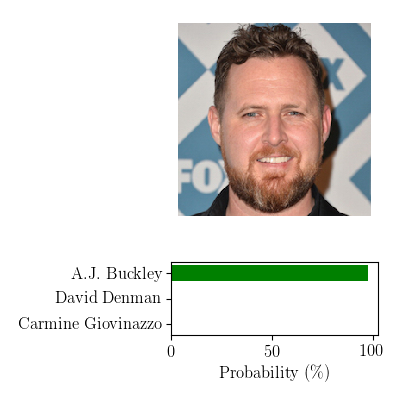

In [6]:
def horizontal_bar_chart(img):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(3, 1)
    img_ax = plt.subplot(gs[:2, 0])
    img_ax.imshow(img.astype(np.uint8))
    img_ax.set_axis_off()
    
    bar_ax = plt.subplot(gs[2, 0])
    
    class_probabilities = classify(img)[0][:3]
    indices = np.arange(len(class_probabilities)) / 2
    probabilities = [c[1] for c in class_probabilities]
    names = [c[0][2:-1].replace("_", " ") for c in class_probabilities]
    
    bar_ax.barh(indices, probabilities, color='green', height=0.3, tick_label=names)
    bar_ax.invert_yaxis()
    x_axis_formatter = FuncFormatter(lambda x, _: "{:.0%}".format(x))
    bar_ax.xaxis.set_major_formatter(x_axis_formatter)
    bar_ax.set_xlabel("Probability ($\%$)")
    fig.tight_layout()
    
    # TODO show percentage

horizontal_bar_chart(img)

## Crafting adversarial examples

### Initialization
Copy the placeholder into the variable which is the input to the computational graph.

In [7]:
x = tf.placeholder(tf.float32, (224, 224, 3))

# Set up trainable adversarial input
x_hat = img_var
assign_op = tf.assign(x_hat, x)

### Gradient descent step

Use gradient descent to maximize the log probability of the desired output class.

In [8]:
learning_rate = tf.placeholder(tf.float32, ())
y_hat = tf.placeholder(tf.int32, ())

labels = tf.one_hot(y_hat, 2622)
loss_sample = tf.nn.softmax_cross_entropy_with_logits(logits=cnn_output_logits, labels=[labels])
loss = tf.reduce_sum(loss_sample)
optimization_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, var_list=[x_hat])

### Projection step
Keep adversarial example visually close to the original image. Clip to `[0, 255]` range.

In [9]:
epsilon = tf.placeholder(tf.float32, ())

below = x - epsilon
above = x + epsilon
epsilon_clipped = tf.clip_by_value(x_hat, below, above)
# Clip such that result is a valid image
b, g, r = tf.split(epsilon_clipped, num_or_size_splits=3, axis=2)
b_clipped = tf.clip_by_value(b, -93.5940, 255 - 93.5940)
g_clipped = tf.clip_by_value(g, -104.7624, 255 - 104.7624)
r_clipped = tf.clip_by_value(r, -129.1863, 255 - 129.1863)
projected = tf.concat([b_clipped, g_clipped, r_clipped], axis=2)

with tf.control_dependencies([projected]):
    project_step = tf.assign(x_hat, projected)

### Execution

Turn Mr. Buckley into Steve Jobs!

In [10]:
demo_epsilon = 5.0
demo_learning_rate = 1e4
demo_steps = 80
demo_target = 2359 # Steve Jobs

# Initialization step
img_preprocessed = VGGFace.preprocess(img)
sess.run(assign_op, feed_dict={x: img_preprocessed})

# Projected gradient descent
for i in range(demo_steps):
    # Gradient descent step
    _, loss_val = sess.run([optimization_step, loss], feed_dict={learning_rate: demo_learning_rate, y_hat: demo_target})
    # Projection step
    sess.run(project_step, feed_dict={x: img_preprocessed, epsilon: demo_epsilon})
    # Pront progress after every 10 steps
    if (i + 1) % 10 == 0:
        print("Step: {:d}, loss {:3.2f}".format(i + 1, loss_val))
        
# Retrieve the adversarial example
adv = x_hat.eval()

Step: 10, loss 4.28
Step: 20, loss 0.86
Step: 30, loss 0.35
Step: 40, loss 0.23
Step: 50, loss 0.17
Step: 60, loss 0.12
Step: 70, loss 0.10
Step: 80, loss 0.08


<IPython.core.display.Javascript object>


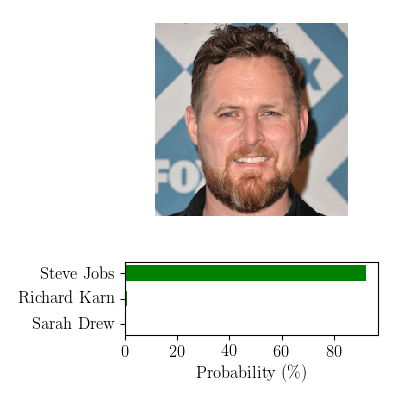

In [11]:
recovered_img = VGGFace.undo_preprocessing(adv)
recovered_img_uint8 = np.rint(recovered_img).astype(np.uint8)
horizontal_bar_chart(recovered_img_uint8)

<IPython.core.display.Javascript object>


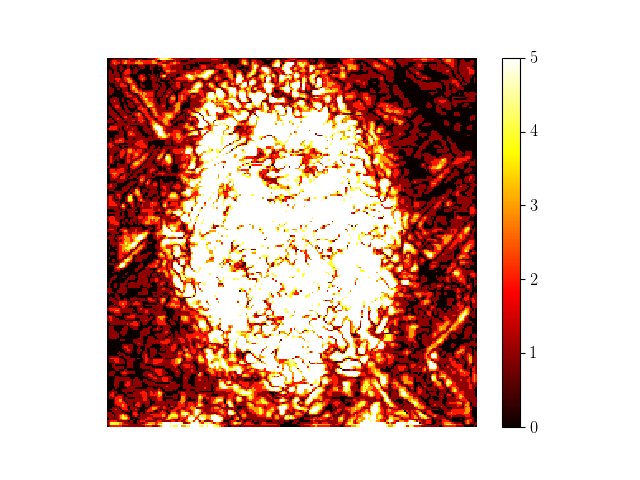

In [23]:
fig = plt.figure()
plt.imshow(np.max(np.abs(recovered_img_uint8 - img), axis=2), cmap="hot")
plt.axis("off")
plt.colorbar()

# Overflow the softmax for fun and profit

We need to achieve `np.exp(710)`

In [12]:
negative_max = -tf.reduce_max(cnn_output_logits)
smashing_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(negative_max, var_list=[x_hat])

demo_epsilon = 25.0
demo_learning_rate = 1e4
demo_steps = 50

# Initialization step
img_preprocessed = VGGFace.preprocess(img)
sess.run(assign_op, feed_dict={x: img_preprocessed})

# Projected gradient descent
for i in range(demo_steps):
    # Gradient descent step
    _, max_val = sess.run([smashing_step, negative_max], feed_dict={learning_rate: demo_learning_rate})
    # Projection step
    sess.run(project_step, feed_dict={x: img_preprocessed, epsilon: demo_epsilon})
    # Pront progress after every 10 steps
    if (i + 1) % 10 == 0:
        print("Step: {:d}, max val {:8.2f}".format(i + 1, -max_val))
        print(np.exp(-max_val))
        
# Retrieve the adversarial example
maximum_adv = x_hat.eval()

Step: 10, max val    47.95
6.67181e+20
Step: 20, max val    71.71
1.39588e+31
Step: 30, max val    90.17
inf


/home/explicat/uni/image-forensics/ml/lib/python3.5/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp


Step: 40, max val    99.83
inf
Step: 50, max val   110.06
inf


[[ nan   0.   0. ...,   0.   0.   0.]]


/home/explicat/uni/image-forensics/ml/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/home/explicat/uni/image-forensics/ml/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


<IPython.core.display.Javascript object>


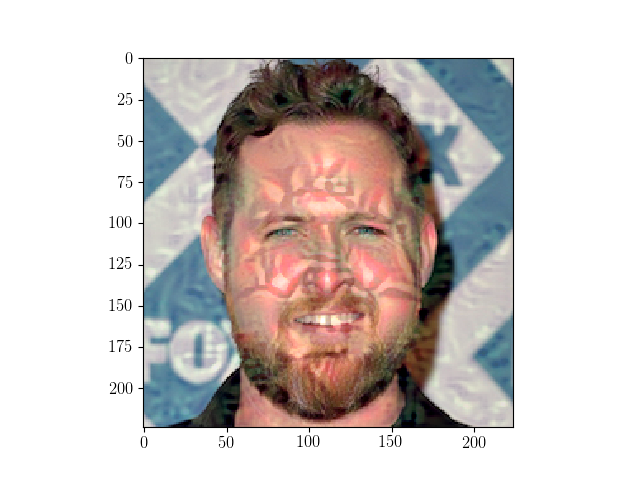

In [22]:
recovered_max_img = VGGFace.undo_preprocessing(maximum_adv)
recovered_max_img_uint8 = np.rint(recovered_max_img).astype(np.uint8)

logits_vals = sess.run(cnn_output_logits, feed_dict={x: VGGFace.preprocess(recovered_max_img_uint8)})
print(np.exp(logits_vals) / np.sum(np.exp(logits_vals)))

plt.figure()
plt.imshow(recovered_max_img_uint8)

<IPython.core.display.Javascript object>


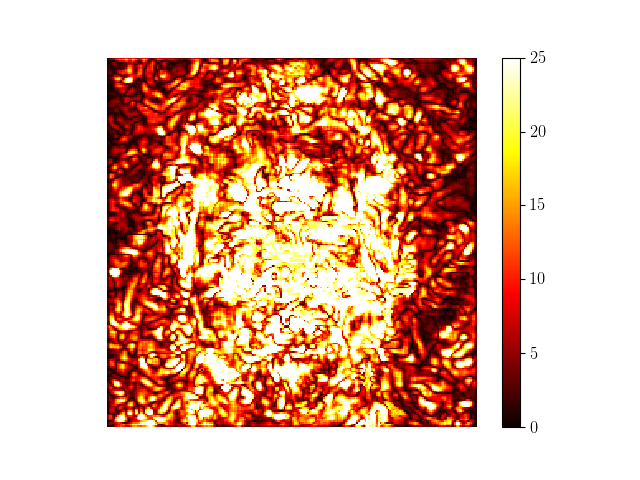

In [24]:
fig = plt.figure()
plt.imshow(np.max(np.abs(recovered_max_img_uint8 - img), axis=2), cmap="hot")
plt.axis("off")
plt.colorbar()